<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

# Data Science Basics in Python Series

## Chapter II: NumPy ndarrays for Working with Gridded Data in Python 

### Michael Pyrcz, Associate Professor, The University of Texas at Austin 

*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

#### Regular Gridded Data Structures / ndarrays in Python for Engineers and Geoscientists 

This is a tutorial for / demonstration of **Regular Gridded Data Structures in Python**.  In Python, a common tool for dealing with Regular Gridded Data Structures is the *ndarray* from the **NumPy Python package**

* Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). DOI: 0.1038/s41586-020-2649-2. [Nature paper](https://www.nature.com/articles/s41586-020-2649-2)

This tutorial includes the methods and operations that would commonly be required for Engineers and Geoscientists working with Regularly Gridded Data Structures for the purpose of:

1. Data Checking and Cleaning
2. Data Mining / Inferential Data Analysis
3. Predictive Modeling

for Data Analytics, Geostatistics and Machine Learning.

##### Gridded Data Structures

In Python we commonly store our data in two formats, tables and arrays. For sample data with typically multiple features $1,\ldots,m$ over $1,\ldots,n$ samples we will work with tables. For exhaustive 2D maps and 3D models (usually representing a single feature) on a regular grid over $[1,\ldots,n_{1}], [1,\ldots,n_{2}],\ldots,[1,\ldots,n_{dim}]$, where $n_{dim}$ is the number of dimensions, we will work with arrays. 

* It is always possible to add another dimension to our array to include multiple features, $1,\ldots,m$, over all locations, and to work in 2D, 3D, and beyond!

|              | $ix = 0$    | $ix = 1$    |        | $ix = n_x - 1$  |
| -----------  | ----------- | ----------- | ----------- | ---------  |
| $iy = 0$     | $z[iy,ix]$  | $z[iy,ix]$  | $\ldots$   | $z[iy,ix]$ |
| $iy = 1$     | $z[iy,ix]$  | $z[iy,ix]$  | $\ldots$   | $z[iy,ix]$ |
| $\ldots$     | $\ldots$    | $\ldots$    | $\ldots$   | $\ldots$   |
| $iy = n_y-1$ | $z[iy,ix]$  | $z[iy,ix]$  | $\ldots$   | $z[iy,ix]$ |

In geostatistical workflows the tables are typically sample data from wells and drill holes and the grids are the interpolated or simulated models or secondary data from sources such as seismic inversion.

The NumPy package provides a convenient *ndarray* object for working with regularly gridded data. In the following tutorial we will focus on practical methods with *ndarray*s.  There is another section available on Tabular Data Structures that focuses on DataFrames at https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/PythonDataBasics_DataFrame.ipynb.

#### Project Goal

Learn the basics for working with Regular Gridded Data Structures in Python to build practical spatial data analytics, geostatistics and machine learning workflows.

#### Caveats

I included methods that I have found useful for building my geoscience and engineering workflows for subsurface modeling. I think they should be accessible to most geoscientists and engineers. Certainly, there are more advanced, more compact, more efficient methods to accomplish the same tasks. I tried to keep the methods simple. I appreciate feedback and I will use it to improve this tutorial periodically.

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import os                                       # operating system
import numpy as np                              # arrays and matrix math
import matplotlib.pyplot as plt                 # plotting
from scipy import stats                         # summary statistics

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see below) data file in this directory.  When we are done with this tutorial we will write our new dataset back to this directory.  

In [2]:
os.chdir("c:/PGE383")                           # set the working directory

#### Loading Binary Data to an ndarray

Let's load the 2D porosity map from the provide binary file [porosity_truth_map.dat](https://github.com/GeostatsGuy/GeoDataSets/blob/master/porosity_truth_map.dat).  

* This binary file was created with the NumPy ndarray member function 'tofile'.  

* The binary file does not store any information about the array ([see docs](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.tofile.html)). So when we read our 2D porosity map we get a 1D ndarray of porosity values. 

In [3]:
porosity_1d_array = np.fromfile('porosity_truth_map.dat') # load binary data file
print('porosity_1d_array is a ' + str(type(porosity_1d_array)) + '.')

porosity_1d_array is a <class 'numpy.ndarray'>.


#### Preview ndarrays

Entering the name of a ndarray will output a preview of the array.

In [4]:
porosity_1d_array

array([ 9.47058121,  9.91782937,  9.9798204 , ..., 10.76326531,
       10.30917151, 10.86594983])

#### Preview ndarrays

Notice that NumPy constrains the number of displayed elements.

* This prevents us from attempting an impractical visualization of a large number of elements

* We can use NumPy's set_printoptions() function to control the printing of arrays

* precision is the number of decimals, threshold is the number elements to trigger summarization

In [5]:
#np.set_printoptions(precision = 3, threshold=1.0e10) # remove truncation from array visualization
np.set_printoptions(precision = 3, threshold=100)   # remove truncation from array visualization
porosity_1d_array

array([ 9.471,  9.918,  9.98 , ..., 10.763, 10.309, 10.866])

#### Check the Size and Dimensions of ndarrays

Now we have an ndarray to work with. Let's check the shape:

* The ndarray member [my_ndarray].shape stores the number of dimensions and the size in each dimension in a tuple (an immutable list)

* Note, the original map is a 100x100 2D ndarray so we load it from binary as a 10,000x1 1D ndarray. 

In [6]:
porosity_1d_array.shape                         # size and number of dimensions

(10000,)

#### Reshape ndarrays

We use the member function [my_ndarray].reshape() to restore the loaded 1D array to a 2D ndarray

* the inputs are the original array and the new shape as int or tuple of ints
* in 2D the standard Python order is left to right for each row from top to bottom
* it is possible to set the order = 'C' for C-like index or 'F' for Fortran index

In [7]:
porosity_map = np.reshape(porosity_1d_array,[100,100]) # reshape the array to 100 x 100
print('The porosity map has a shape ' + str(porosity_map.shape) + '.')
ny = porosity_map.shape[0]                      # get the array nx
nx = porosity_map.shape[1]                      # get the array ny
print('Our 2D array has number of x cells = ' + str(nx) + ', and y cells = ' + str(ny) + '.' )

The porosity map has a shape (100, 100).
Our 2D array has number of x cells = 100, and y cells = 100.


#### Flatten ndarrays

There are times that you want to 'flatten' a multidimensional array to 1D ndarrays

* There is a member function [my_ndarray].flatten() to do this
* We lose the information on endianness, but in some cases that is desirable
* For example when finding the minimum value over the ndarray or plotting a histogram (see below)

In [8]:
flatten_porosity_map = porosity_map.flatten()   # flatten the 2D map
print('The flattened porosity map has a shape ' + str(flatten_porosity_map.shape) + '.')

The flattened porosity map has a shape (10000,).


#### Read and Write Binary Files

Let's close the loop, write out the array and read it back in, to demonstrate the ndarray output member function [my_ndarray].tofile(). 

* We save the map as binary, read and back in
* We compare the 2 ndarrays with the NumPy function np.array_equal(). 
* Note we reshape the loaded ndarray, recall the dimension (2D was lost in the save to a binary file).

In [9]:
porosity_map.tofile("porosity_test.dat")        # save our 2D array to 1D binary file
porosity_test = np.fromfile('porosity_test.dat') # read the 1D binary back to 1D array
check = np.array_equal(porosity_map,np.reshape(porosity_test,[100,100])) # check if loaded = saved
print('Is the array we wrote out and read back in the same as the original array? ' + str(check) + '.')

Is the array we wrote out and read back in the same as the original array? True.


#### Write ASCII Comma Delimited Files

Let's write our map to an comma delimited ASCII file (*.csv). 

* These files are readible in any text editor

* These files are easy to load into Excel

* We can specify any delimiter, a space is the default 

In [10]:
np.savetxt("porosity_map.csv", porosity_map, delimiter=",") # save our 2D array to 2D comma delimited

#### Read ASCII Comma Delimited Files

Now we can load the 2D map back in and confirm the we have the same ndarray that we started with.

* When we save a 2D ndarray to an ASCII file we retain the shape, indexing

In [11]:
porosity_map_test = np.loadtxt("porosity_map.csv", delimiter=",") # load the csv
test = np.array_equal(porosity_map,porosity_map_test) # check if the arrays are the same
print('Is the array we wrote out and read back in the same as the original array? ' + str(test) + '.')
print('The loaded array has a shape ' + str(porosity_map_test.shape) + '.')

Is the array we wrote out and read back in the same as the original array? True.
The loaded array has a shape (100, 100).


#### Read and Write Geo-EAS files - Optional, Depends on GeostatsPy Package

* This block is optional
* The [GeostatsPy](https://pypi.org/project/geostatspy/) Python Package (Pyrcz et al., 2019) has a function to write 2D/3D ndarrays to Geo-EAS format 
* This is the standard file format of [GSLIB](http://www.gslib.com/) (Deutsch and Journel, 1998)
* We write then read back in the 2D ndarray and confirm it is the same with np.array_equal() NumPy function

In [12]:
# optional - depends on GeostatsPy
import geostatspy.GSLIB as GSLIB                # geostatspy for geostatistics functions
GSLIB.ndarray2GSLIB(porosity_map,"porosity_map_GSLIB.out","porosity") # save the gridded data to Geo-EAS format
porosity_map_test2, col_name = GSLIB.GSLIB2ndarray("porosity_map_GSLIB.out",0,nx,ny) # save as Geo_EAS file
test = np.array_equal(porosity_map,porosity_map_test2) # check if the arrays are the same
print('The ndarray from the file we read is the same as before we saved it, ' + str(test))

The ndarray from the file we read is the same as before we saved it, True


#### Slicing ndarrays

Just like Pandas DataFrames we can slice NumPy ndarrays.

* recall the Python indexing is $z[y_{top} \rightarrow y_{bottom}][x_{left} \rightarrow x_{right}]$

* Some common notation - **:** all, **:5** from 0 to 4, **96:** from 96 to end
* and more advanced - **1:10:3** from 1 through 9, take every 3rd row or column

Let's do our first slice of top left corner for ease of visualization

In [13]:
top_corner = porosity_map[:5,:5]                # extract the lop left corner
print('The type for the slice is ' + str(type(top_corner)) + '.')
print('The shape of the slice is ' + str(top_corner.shape) + '.')
top_corner

The type for the slice is <class 'numpy.ndarray'>.
The shape of the slice is (5, 5).


array([[ 9.471,  9.918,  9.98 ,  9.916, 10.699],
       [ 8.676,  8.945,  9.267, 10.003, 11.012],
       [ 9.139,  8.934,  9.878, 10.908, 10.909],
       [ 8.335,  8.695,  9.284, 10.609, 11.524],
       [ 9.359,  9.917, 10.049, 10.772, 11.161]])

#### Slicing ndarrays

Here's an example where we extract the first column of the top corner.

* This is the furthest left column of the top corner.

In [14]:
first_column = top_corner[:,0]                  # extract the first column
print('The shape of the slice is ' + str(first_column.shape) + '.')
first_column

The shape of the slice is (5,).


array([9.471, 8.676, 9.139, 8.335, 9.359])

#### Slicing ndarrays

Here's an example where we extract the bottom 2 rows.

* This is the bottom 2 rows of the top corner. We use negative integers to count from the end.

In [15]:
last_2_rows = top_corner[-2:,:]
print('The shape of the slice is ' + str(last_2_rows.shape) + '.')
last_2_rows

The shape of the slice is (2, 5).


array([[ 8.335,  8.695,  9.284, 10.609, 11.524],
       [ 9.359,  9.917, 10.049, 10.772, 11.161]])

#### Slicing ndarrays

Is slicing a deep or shallow copy?

* **shallow copy** - point to the same memory, change one and both are changed

* **deep copy** - make a new copy in memory, change one only one changes

Let's do a quick check.

In [16]:
print('The original value for porosity_map at [99,99] is ' + str(porosity_map[99,99]) + '.')
bottom_right_corner = porosity_map[-3:,-3:]     # make a slice
bottom_right_corner[2,2] = -13.0                # change a value in our slice
porosity_map                                    # check the original ndarray

The original value for porosity_map at [99,99] is 10.865949834361123.


array([[  9.471,   9.918,   9.98 , ...,   8.087,   7.999,   7.675],
       [  8.676,   8.945,   9.267, ...,   9.101,   8.915,   8.722],
       [  9.139,   8.934,   9.878, ...,   8.432,   9.246,   8.535],
       ...,
       [  8.356,   9.193,   9.207, ...,  10.641,  12.386,  12.626],
       [  8.733,   9.15 ,   9.277, ...,  11.116,  11.357,  11.885],
       [  9.096,   9.749,  10.012, ...,  10.763,  10.309, -13.   ]])

#### Slicing ndarrays

Slicing is a shallow copy, when we modify a slice the original ndarray is updated.

* Let's restore the value of the lower, right element in our 2D ndarray

In [17]:
porosity_map[-1:,-1:] = 10.866                  # restore the lower, right element value

#### Reading Elements from ndarrays

Here's an example where we extract a specific element.

* When we do this a single value is returned, type is the element type and not an ndarray 

In [18]:
single_element = porosity_map[2,2]              # extract an element
#single_element = porosity_map[2][2]             # this does the same thing
print('The type for a single element is ' + str(type(single_element)) + '.')
single_element

The type for a single element is <class 'numpy.float64'>.


9.877516184936288

#### Visualizing ndarrays with Line Plots

By default if we pass a 2D ndarray to MatPlotLib.plot() it considers each column to be a separate line plot.

* If we pass a slice of the first 3 columns we will see each column as a line plot.

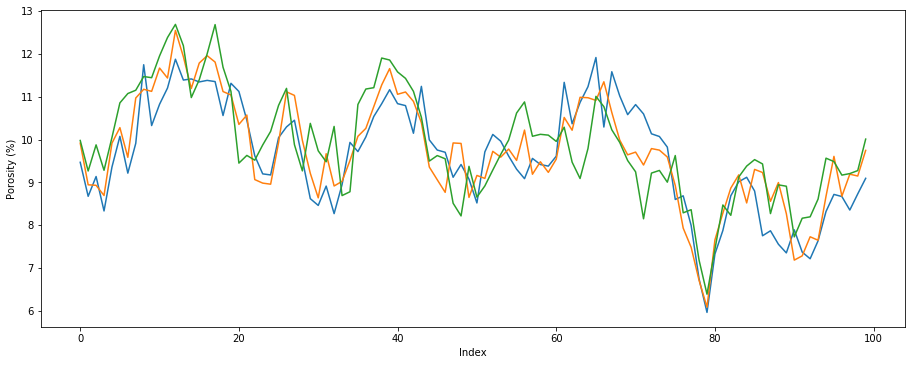

In [19]:
plt.plot(porosity_map[:,:3])                    # plot the first 3 columns
plt.xlabel('Index'); plt.ylabel('Porosity (%)') # add labels to axes

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2) # set the plot scale
plt.show()                                      # close the plot

#### Visualizing ndarrays with Line Plots

We can also explicity, separately plot columns and rows.

* Note, I can mix rows and columns since we explicity state the index

* To explicitly provide the index we use NumPy.linspace() to get an array of 0,1,2...,98,99 (more later)

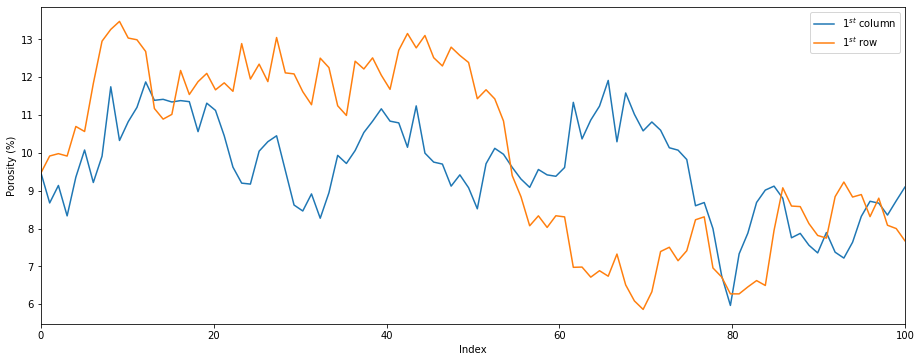

In [20]:
plt.plot(np.linspace(0,100,100),porosity_map[:,0], label = '$1^{st}$ column') # plot the first column
plt.plot(np.linspace(0,100,100),porosity_map[0,:], label = '$1^{st}$ row') # plot the first column
plt.xlim([0,100])                               # specify the min and max
plt.xlabel('Index'); plt.ylabel('Porosity (%)') # add labels to axes
plt.legend()                                    # add a legend
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2) # set the plot scale
plt.show()                                      # close the plot

#### Visualizing 2D ndarrays, Specify the Coordinates

In order to plot a 2D ndarray we need to know the coordinates. A simple specification is possible by assuming: 

* equal element sizes, regular grid

* alignment with the X and Y coodinates, no rotation

We specify the following:

* extents of the array in X, **xmin** and **xmax**, and Y, **ymin** and **ymax** 

* cell size, **cell_size**

* color bar, extents of feature, **vmin** and **vmax** and color map inferno

In [21]:
xmin = 0.0;xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cell_size = 10.0; vmin = 4.0; vmax = 16.0; cmap = plt.cm.inferno

#### Visualizing 2D ndarrays - Optional, Depends on GeostatsPy Package

The GeostatsPy package includes a convenience function for plotting 2D gridded data, like 2D ndarrays
* The function is similar to GSLIB's pixelplt function

* It uses MatPlotLib functionality, produces a fine contour plot

* Reads the index correctly, but indicates a lower left origin (Geo-EAS format) 

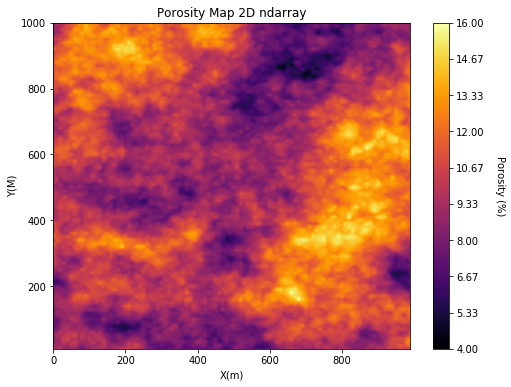

In [22]:
# optional - depends on GeostatsPy
import geostatspy.GSLIB as GSLIB                # for pixelplots
GSLIB.pixelplt(porosity_map,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,"Porosity Map 2D ndarray","X(m)","Y(M)","Porosity (%)",cmap,"Porosity_Map")
plt.show()                                      # close the plot

#### Visualizing 2D ndarrays

MatPlotLib provides a lot of functionality for plotting 2D ndarrays

* Let's make a similar plot with the MatPlotLib.contour() command
* As you can see, there's a good reason for the GeostatsPy.pixelplt() function

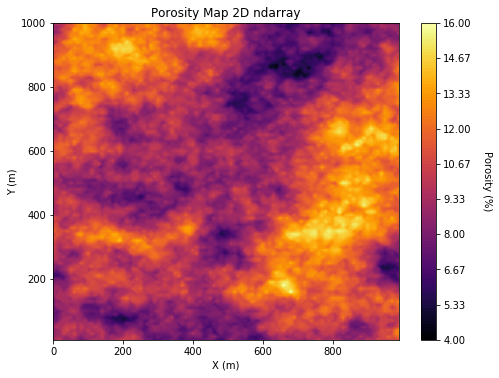

In [23]:
xx, yy = np.meshgrid(                           # make 2D ndarrays with x and y coordinates
  np.arange(xmin,xmax,cell_size), np.arange(ymax, ymin, -1 * cell_size)
)
im = plt.contourf(xx,yy,porosity_map,cmap=cmap,vmin=vmin,vmax=vmax, # contour plot
  levels=np.linspace(vmin, vmax, 100),
)
plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Porosity Map 2D ndarray') # label the axes
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10)) # make a color bar
cbar.set_label('Porosity (%)', rotation=270, labelpad=20) # label the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2) # set the plot scale
plt.show()                                      # close the plot

#### Visualizing 2D ndarrays

MatPlotLib provides a lot of functionality for plotting 2D ndarrays

* Let's make a similar plot with the MatPlotLib.imshow() command
* There is no interpolation between the elements, we see the ndarray elements

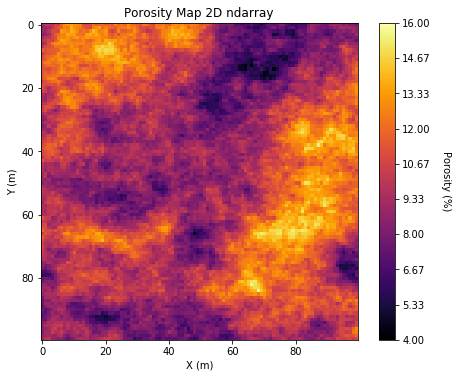

In [24]:
im = plt.imshow(porosity_map,vmin=vmin,vmax=vmax,cmap=cmap) # plot the 2D array
plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Porosity Map 2D ndarray') # label the axes
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10)) # make a color bar
cbar.set_label('Porosity (%)', rotation=270, labelpad=20) # label the color bar

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2) # set the plot scale
plt.show()                                      # close the plot

#### Summary Statistics from ndarrays

Let's try some summary statistics with a function from [SciPy](https://www.scipy.org/). 

* Many stats methods expect a 1D array, so we must flatten the 2D ndarray   
* If we don't flatten, we will get separate summary statistics for each column

In [25]:
stats.describe(porosity_map.flatten())          # various summary statistics

DescribeResult(nobs=10000, minmax=(3.907361729887783, 15.807357455360307), mean=10.000000005016563, variance=4.000400048693306, skewness=0.13942790638620003, kurtosis=-0.5302829766005894)

#### Statistics from ndarrays

We also have a variety of ndarray member functions for statistics.  

* The calculation is completed over all elements without the need for flattening. 

In [26]:
mean_por = porosity_map.mean()                  # individual summary statistics
stdev_por = porosity_map.std()
min_por = porosity_map.min()
max_por = porosity_map.max()
print('Summary Statistics of Porosity \n Mean = ' + str(mean_por) + ', StDev = ' + str(stdev_por))
print(' Min = ' + str(min_por) + ', Max = ' + str(max_por))

Summary Statistics of Porosity 
 Mean = 10.000000005016563, StDev = 2.000000002172109
 Min = 3.907361729887783, Max = 15.807357455360307


#### Statistics for ndarrays

We can also use NumPy functions that accept ndarrays as arguments for even more statistics.

In [27]:
mean_por = np.mean(porosity_map)                # individual summary statistics
stdev_por = np.std(porosity_map)
min_por = np.min(porosity_map)
max_por = np.max(porosity_map)
P10_por,P90_por = np.percentile(porosity_map,[0.10,0.90])
print('Summary Statistics of Porosity \n Mean = ' + str(mean_por) + ', StDev = ' + str(stdev_por))
print(' Min = ' + str(min_por) + ', Max = ' + str(max_por))
print(' P10 = ' + str(P10_por) + ', P90 = ' + str(P90_por))

Summary Statistics of Porosity 
 Mean = 10.000000005016563, StDev = 2.000000002172109
 Min = 3.907361729887783, Max = 15.807357455360307
 P10 = 4.787387901474506, P90 = 5.715627120619864


#### Reading and Writing Elements of ndarrays

We can read and write individual elements of our ndarray

* Remember the previously discussed indexing scheme

In [28]:
array_element = porosity_map[0,0]               # read value at location 0,0, top left corner
print('Porosity at location 0,0 in our ndarray is ' + str(array_element) + '.')
porosity_map[0,0] = 10.0000                     # write value at location 0,0, top left corner
print('Porosity at location 0,0 in our ndarray is now ' + str(porosity_map[0,0]) + '.')

Porosity at location 0,0 in our ndarray is 9.470581208066502.
Porosity at location 0,0 in our ndarray is now 10.0.


#### Check ndarray for Missing Values

We can also check for invalid or missing values, NaNs (Not a Number), in our ndarray. 

* We use the NumPy function NumPy.isnan() to return a boolean array of same size (True if NaN)
* Then we use [my_ndarray].any() to check for any True values

In [29]:
porosity_map[0,1] = np.nan                      # add another NaN
porosity_map[2,1] = np.nan                      # add another NaN
result = np.isnan(porosity_map).any()
print('Are there any missing values in this array? ' + str(result))

Are there any missing values in this array? True


#### Find Missing Values in a ndarray

Now we have NaN's in our ndarray, let's demonstrate how to find them.  

* NaN's could cause issues with our calculations.  
* We can get a list of indices of the elements in our ndarray with NaN's
* We use the NumPy.argwhere() function to return the indices with True in the 2D boolean ndarray 

In [30]:
nan_list = np.argwhere(np.isnan(porosity_map))  # get list of indices of array with NaNs
print('The indices with missing values are:\n' + str(nan_list) + '.')

The indices with missing values are:
[[0 1]
 [2 1]].


#### Constant Value Imputation for an ndarray 

Now that we have identified the precense of missing values we can update them.

* NumPy.nan_to_num() function can be to replace the NaN values with a constant

In [31]:
porosity_map = np.nan_to_num(porosity_map,nan=0.01) # replace NaN values
porosity_map

array([[1.000e+01, 1.000e-02, 9.980e+00, ..., 8.087e+00, 7.999e+00,
        7.675e+00],
       [8.676e+00, 8.945e+00, 9.267e+00, ..., 9.101e+00, 8.915e+00,
        8.722e+00],
       [9.139e+00, 1.000e-02, 9.878e+00, ..., 8.432e+00, 9.246e+00,
        8.535e+00],
       ...,
       [8.356e+00, 9.193e+00, 9.207e+00, ..., 1.064e+01, 1.239e+01,
        1.263e+01],
       [8.733e+00, 9.150e+00, 9.277e+00, ..., 1.112e+01, 1.136e+01,
        1.189e+01],
       [9.096e+00, 9.749e+00, 1.001e+01, ..., 1.076e+01, 1.031e+01,
        1.087e+01]])

#### Making ndarrays from Scratch

There are various methods to make *ndarray*s from scratch.  

* In some cases, our ndarrays are small enough we can just write them like this
* Note, we list the rows from top to bottom

In [32]:
my_array = np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11]]) # make a ndarray by scratch
print('The shape of my ndarry is ' + str(my_array.shape) + '.')
my_array

The shape of my ndarry is (3, 4).


array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

#### Making ndarray of Zeros

We can make an array full of zeros.

* we use the NumPy.zeros() function
* I find this useful in many workflows when I know how much memory I will need in advance

In [33]:
zeros = np.zeros([2,5])                         # make a ndarray by scratch
print('The shape of my ndarry is ' + str(zeros.shape) + '.')
zeros

The shape of my ndarry is (2, 5).


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

#### Making ndarrays of Constant Values

You can also make an ndarray with a constant with the NumPy.full() function

In [34]:
value = 13.0
constants = np.full([2,3],value)                # make a ndarray by scratch
print('The shape of my ndarry is ' + str(constants.shape) + '.')
constants

The shape of my ndarry is (2, 3).


array([[13., 13., 13.],
       [13., 13., 13.]])

#### Making ndarrays of Random Values

You can also make an ndarray with ranodm values with the NumPy.random.rand() function

In [35]:
seed = 73073
np.random.seed(seed=seed)
random = np.random.rand(3,3)                    # make an ndarray by scratch
print('The shape of my ndarry is ' + str(random.shape) + '.')
random

The shape of my ndarry is (3, 3).


array([[0.761, 0.232, 0.938],
       [0.484, 0.385, 0.843],
       [0.576, 0.201, 0.013]])

#### Making ndarrays of Evenly Spaced Numbers

It is often useful to make an ndarray of evenly spaced values with np.linspace() function. For example:

* bin boundaries
* plot indices (see above)

In [36]:
even_spaced = np.linspace(0,99,100)             # 100 values from 0 to 99 = 0,1,2,...,98,99
even_spaced

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

#### Boolean Operations with ndarrays

We can use any boolean operation to filter and search over ndarrays. Let's visualize this this boolean ndarray. Output is True (1) and False (0).

* This returns a boolean array of the same size of the original array
* True when the condition holds and False otherwise

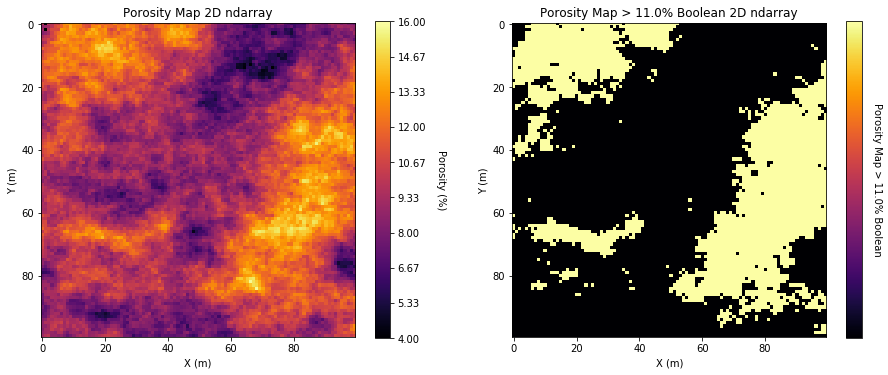

In [37]:
threshold = 11.0                                # select a porosity threshold
indicator_map = porosity_map > threshold        # apply operator

plt.subplot(121)                                # plot the original porosity map
im = plt.imshow(porosity_map,vmin=vmin,vmax=vmax,cmap=cmap) # plot the 2D array
plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Porosity Map 2D ndarray') # label the axes
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10)) # make a color bar
cbar.set_label('Porosity (%)', rotation=270, labelpad=20) # label the color bar

plt.subplot(122)                                # plot the boolean map
im = plt.imshow(indicator_map,vmin=0.0,vmax=1.0,cmap=cmap) # plot the 2D array
plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title("Porosity Map > " + str(threshold) + "% Boolean 2D ndarray") # label the axes
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10)) # make a color bar
cbar.set_label("Porosity Map > " + str(threshold) + "% Boolean", rotation=270, labelpad=20) # label the color bar

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2) # set the plot scale
plt.show()                                      # close the plot

#### Boolean Operations with ndarrays

We can extract the samples based on a 2D boolean ndarray the same size as the original ndarray

* We pass the boolean array to the original ndarray 
* The output is a 1D ndarray with all the element associated with the true values

In [38]:
my_array = np.array([[1,2],[3,4]])              # make a simple ndarray
print('My original array: \n ' + str(my_array))
my_boolean_array = np.array([[True,False],[False,True]]) # make a simple boolean array
print('\n My boolean array: \n ' +str(my_boolean_array))
true_values = my_array[my_boolean_array]        # extract the values at True indices

print('The extracted elements ' + str(true_values))
true_values

My original array: 
 [[1 2]
 [3 4]]

 My boolean array: 
 [[ True False]
 [False  True]]
The extracted elements [1 4]


array([1, 4])

#### Working with Extractions from ndarrays

This ability to filter and extract given any condition is quite powerful.

* Let's calculate and plot histogram for porosity below and above our threshold

There are 3167 high porosity elements of a total of 10000.


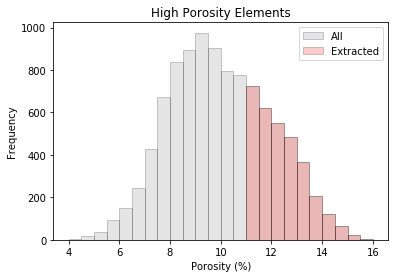

In [39]:
high_porosity = porosity_map[indicator_map]     # extract all porosity values > threshold
print('There are ' + str(high_porosity.size) + ' high porosity elements of a total of ' + str(porosity_map.flatten().size) + '.')
plt.hist(porosity_map.flatten(), color = 'gray', alpha = 0.2, edgecolor = 'black',bins = np.linspace(4,16,25), density = False, label = 'All') # plot a histogram
plt.hist(high_porosity, color = 'red', alpha = 0.2, edgecolor = 'black',bins = np.linspace(4,16,25), density = False, label = 'Extracted') # plot a histogram
plt.xlabel('Porosity (%)'); plt.ylabel('Frequency'); plt.title('High Porosity Elements'); plt.legend()
plt.show()

#### Mathematical Operators with ndarrays

We can apply any mathematical operation with a constant over all ndarray elements

* The math is performed on a 'by-element' basis
* These calculations are much more efficient than attempting to loop over ndarray elements manually

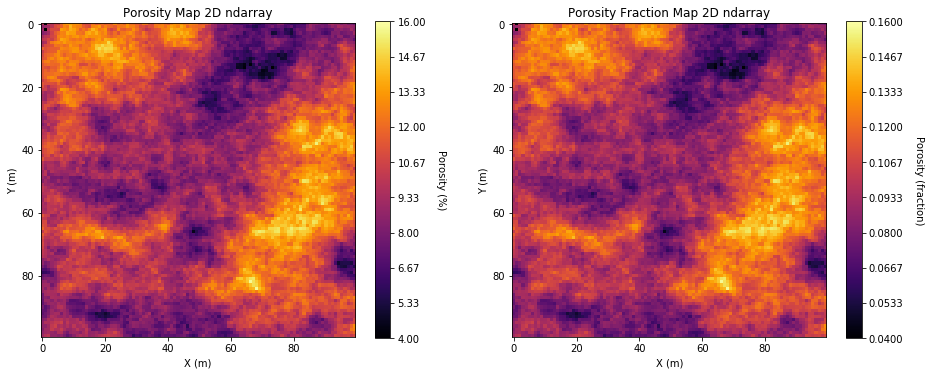

In [40]:
porosity_fraction_map = porosity_map / 100.0    # divide all porosity values by 100

plt.subplot(121)
im = plt.imshow(porosity_map,vmin=vmin,vmax=vmax,cmap=cmap) # plot the 2D array
plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Porosity Map 2D ndarray') # label the axes
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10)) # make a color bar
cbar.set_label('Porosity (%)', rotation=270, labelpad=20) # label the color bar

plt.subplot(122)
im = plt.imshow(porosity_fraction_map,vmin=vmin/100,vmax=vmax/100,cmap=cmap) # plot the 2D array
plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Porosity Fraction Map 2D ndarray') # label the axes
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin/100, vmax/100, 10)) # make a color bar
cbar.set_label('Porosity (fraction)', rotation=270, labelpad=20) # label the color bar

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2) # set the plot scale
plt.show() 

#### Operations with ndarrays

If you have arrays of the same size, you can directly apply mathematical operations between them.

* The math is performed on a 'by-element' basis
* These calculations are much more efficient than attempting to loop over ndarray elements manually

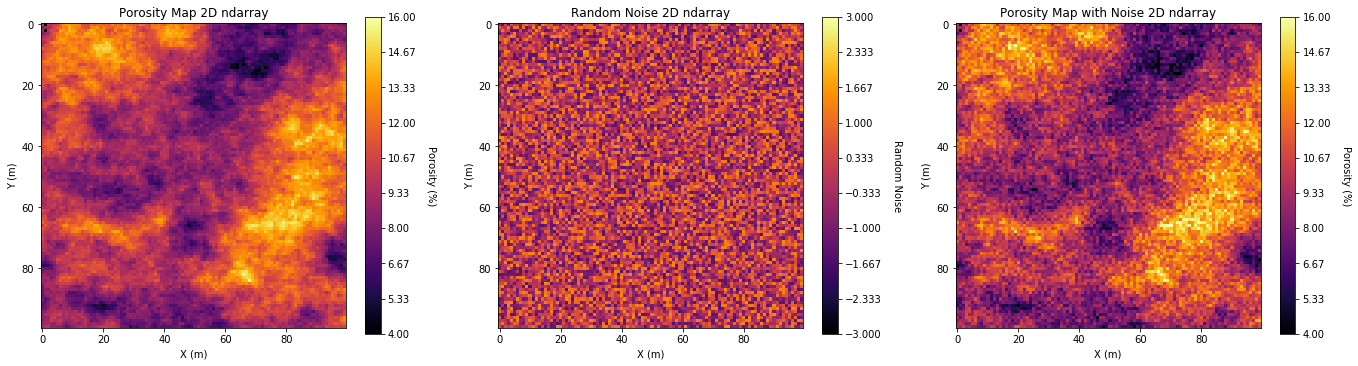

In [41]:
random_map = (np.random.rand(100,100)-0.5)*3.0  # make a random map
porosity_with_noise = porosity_map + random_map # add the porosity and random maps

plt.subplot(131)                                # plot the original porosity map
im = plt.imshow(porosity_map,vmin=vmin,vmax=vmax,cmap=cmap) # plot the 2D array
plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Porosity Map 2D ndarray') # label the axes
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10)) # make a color bar
cbar.set_label('Porosity (%)', rotation=270, labelpad=20) # label the color bar

plt.subplot(132)                                # plot the noise
im = plt.imshow(random_map,vmin=-3,vmax=3,cmap=cmap) # plot the 2D array
plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Random Noise 2D ndarray') # label the axes
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-3, 3, 10)) # make a color bar
cbar.set_label('Random Noise', rotation=270, labelpad=20) # label the color bar

plt.subplot(133)                                # plot the addition of porosity with noise
im = plt.imshow(porosity_with_noise,vmin=vmin,vmax=vmax,cmap=cmap) # plot the 2D array
plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Porosity Map with Noise 2D ndarray') # label the axes
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10)) # make a color bar
cbar.set_label('Porosity (%)', rotation=270, labelpad=20) # label the color bar

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2); plt.show() # set the plot scale and close

#### Conditional Operators  on ndarrays

We can apply the NumPy.where() function to apply a conditional operator on a ndarray

* This is useful for truncating values to an upper limit

* Let's truncate porosity_map 2D ndarray with our previous threshold

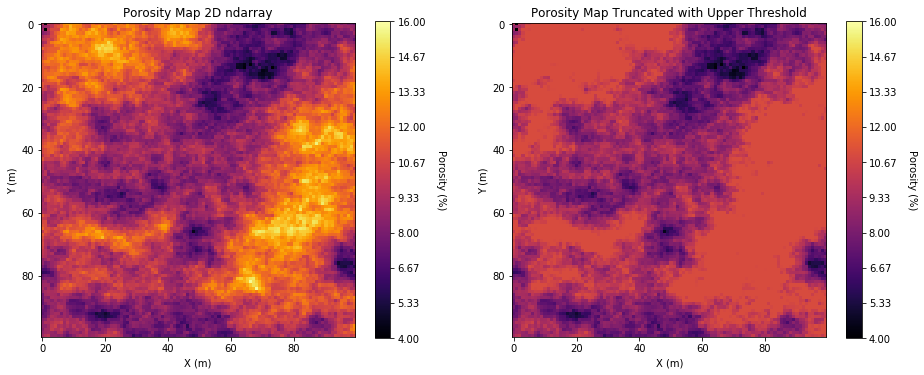

In [42]:
truncated = np.where(porosity_map > threshold, threshold, porosity_map) # truncate the upper tail

plt.subplot(121)                                # plot the original porosity map
im = plt.imshow(porosity_map,vmin=vmin,vmax=vmax,cmap=cmap) # plot the 2D array
plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Porosity Map 2D ndarray') # label the axes
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10)) # make a color bar
cbar.set_label('Porosity (%)', rotation=270, labelpad=20) # label the color bar

plt.subplot(122)                                # plot the addition of porosity with noise
im = plt.imshow(truncated,vmin=vmin,vmax=vmax,cmap=cmap) # plot the 2D array
plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Porosity Map Truncated with Upper Threshold') # label the axes
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10)) # make a color bar
cbar.set_label('Porosity (%)', rotation=270, labelpad=20) # label the color bar

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2) # set the plot scale
plt.show()                                      # close the plot

#### Operations with ndarrays

There may be more complicated operations that you want to perform. You could loop manually to do anything!
* Let's set to np.nan all values outside a cicle centered at the middle of the map
* Challenge yourself to use existing functions for efficient, readable code

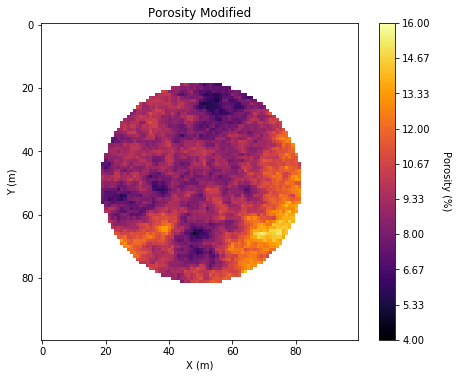

In [43]:
por_mod = np.full([100,100],np.nan)                   # use of loops to manipulate ndarrays
for iy in range(ny):
    for ix in range(nx):
        if ((ix-50)*(ix-50) + (iy-50)*(iy-50)) < 1000:
            por_mod[iy,ix] = porosity_map[iy,ix]

im = plt.imshow(por_mod,vmin=vmin,vmax=vmax,cmap=cmap) # plot the 2D array
plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Porosity Modified') # label the axes
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10)) # make a color bar
cbar.set_label('Porosity (%)', rotation=270, labelpad=20) # label the color bar

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2) # set the plot scale
plt.show()                                      # close the plot

#### Write a ndarray to Geo-EAS - Optional, Depends on GeostatsPy Package

Let's write our new ndarray to a file for storage and to apply with other software such as GSLIB.

In [44]:
# optional - depends on GeostatsPy
GSLIB.ndarray2GSLIB(por_mod,"por_mod_GSLIB.dat","por_mod") # write out 2D array to a Geo-DAS ASCII file

I hope this we helpful,

Michael

#### More About The Author:

### Michael Pyrcz, Associate Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin